In [19]:
import os
from keras.preprocessing.image import ImageDataGenerator 
# https://keras.io/api/preprocessing/image/#image-data-preprocessing
from keras.applications.imagenet_utils import preprocess_input

from keras.applications.vgg16 import VGG16

from keras.models import Model, Sequential

from keras.layers import Dense, Flatten, Dropout

from keras.optimizers import Adam
from keras.losses import binary_crossentropy
from keras.metrics import accuracy

import matplotlib.pyplot as plt
import numpy as np



Verificando si las carpetas necesarias estan disponibles

In [20]:
pathTrain = './dataset/catdog/train'
pathTest = './dataset/catdog/test'

if (os.path.exists(pathTrain) and os.path.exists(pathTest)):
    print('OK')
else:
    print('No existen carpetas')
    print('Descomprima el archivo catdog.zip o puede descargar otro dataset: https://www.kaggle.com/arpitjain007/dog-vs-cat-fastai')


OK


Crear un generador de nuevas imagenes

In [21]:
images_increased = 5
width_shape = 224
height_shape = 224
batch_size = 32

train_datagen = ImageDataGenerator(
    rotation_range=20, # rota 20 grados
    zoom_range=0.2, # zoom
    width_shift_range=0.1, # desplazar 10%
    height_shift_range=0.1,  # desplazar 10%
    horizontal_flip=True, # invertir horizontalmente
    vertical_flip=False,
    preprocessing_function=preprocess_input
)

valid_datagen = ImageDataGenerator(    
    rotation_range=20,
    zoom_range=0.2,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    vertical_flip=False,
    preprocessing_function=preprocess_input)

train_generator = train_datagen.flow_from_directory(  
    pathTrain,
    target_size=(width_shape, height_shape),
    batch_size=batch_size,
    class_mode='binary',
    save_to_dir='./dataset/data/',
    save_format='jpg'
    )

train_generator.next()

validation_generator = valid_datagen.flow_from_directory(  
    pathTest,
    target_size=(width_shape, height_shape),
    batch_size=batch_size,
    class_mode='binary')

Found 400 images belonging to 2 classes.
Found 20 images belonging to 2 classes.


Crear modelo

In [4]:
inputShape = (height_shape, width_shape, 3)

model = VGG16(include_top=False, weights="imagenet", input_shape=inputShape)

Configurar capas para no se entrenadas. Frezar las primeras 10 capas

In [5]:
for layer in model.layers:
    layer.trainable = False

for i, layer in enumerate(model.layers):
    print(i, layer.name, layer.trainable)


0 input_1 False
1 block1_conv1 False
2 block1_conv2 False
3 block1_pool False
4 block2_conv1 False
5 block2_conv2 False
6 block2_pool False
7 block3_conv1 False
8 block3_conv2 False
9 block3_conv3 False
10 block3_pool False
11 block4_conv1 False
12 block4_conv2 False
13 block4_conv3 False
14 block4_pool False
15 block5_conv1 False
16 block5_conv2 False
17 block5_conv3 False
18 block5_pool False


Generar función que agrega capas en la etapa de clasificación

In [6]:
def load_fc_layers(model):
    # add new classifier layers
    newModel = Sequential()
    newModel.add(model)
    newModel.add(Flatten())
    newModel.add(Dense(128, activation='relu'))
    newModel.add(Dropout(rate=0.1))
    newModel.add(Dense(64, activation='relu'))
    newModel.add(Dropout(rate=0.1))
    newModel.add(Dense(64, activation='relu'))
    newModel.add(Dropout(rate=0.1))
    newModel.add(Dense(1, activation='sigmoid'))
    
    return newModel

In [7]:
fullModel = load_fc_layers(model)
for i, layer in enumerate(fullModel.layers):
    print(i, layer.name, layer.trainable)

fullModel.summary()

0 vgg16 True
1 flatten_1 True
2 dense_1 True
3 dropout_1 True
4 dense_2 True
5 dropout_2 True
6 dense_3 True
7 dropout_3 True
8 dense_4 True
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 7, 7, 512)         14714688  
_________________________________________________________________
flatten_1 (Flatten)          (None, 25088)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               3211392   
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 64)                8256      
_________________________________________________________________
dropout_2 (Dropout)          (None, 64)      

Compilar

In [8]:
adam = Adam(learning_rate=0.01)

fullModel.compile(
    optimizer=adam,
    loss=binary_crossentropy,
    metrics=[accuracy]
)

Entrenar

In [9]:
epoch = 200

history = fullModel.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=epoch
)

l_accuracy: 0.8000
Epoch 63/200
13/13 [==============================] - 6s 441ms/step - loss: 0.0593 - accuracy: 0.9275 - val_loss: 0.9759 - val_accuracy: 0.8000
Epoch 64/200
13/13 [==============================] - 6s 457ms/step - loss: 0.2285 - accuracy: 0.8975 - val_loss: 0.1273 - val_accuracy: 0.7500
Epoch 65/200
13/13 [==============================] - 6s 450ms/step - loss: 0.0778 - accuracy: 0.9350 - val_loss: 0.4350 - val_accuracy: 0.8000
Epoch 66/200
13/13 [==============================] - 6s 451ms/step - loss: 0.0571 - accuracy: 0.8975 - val_loss: 0.1412 - val_accuracy: 0.7500
Epoch 67/200
13/13 [==============================] - 6s 468ms/step - loss: 0.0653 - accuracy: 0.9075 - val_loss: 0.0487 - val_accuracy: 0.8500
Epoch 68/200
13/13 [==============================] - 6s 467ms/step - loss: 0.0305 - accuracy: 0.9250 - val_loss: 0.5194 - val_accuracy: 0.8500
Epoch 69/200
13/13 [==============================] - 6s 453ms/step - loss: 0.4080 - accuracy: 0.9125 - val_loss: 1.0

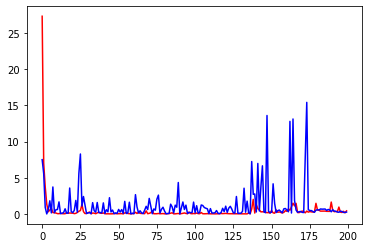

In [13]:
plt.plot(range(len(history.history['loss'])), history.history['loss'], color='red')
plt.plot(range(len(history.history['val_loss'])), history.history['val_loss'], color='blue')

plt.show()

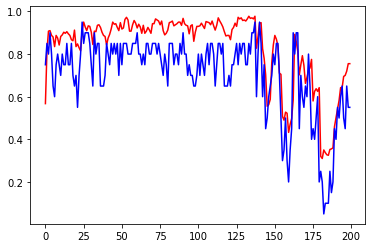

In [14]:
plt.plot(range(len(history.history['accuracy'])), history.history['accuracy'], color='red')
plt.plot(range(len(history.history['val_accuracy'])), history.history['val_accuracy'], color='blue')

plt.show()

Matriz de confusión

In [18]:
Y_pred = fullModel.predict_generator(validation_generator)
y_pred = np.argmax(Y_pred, axis=1)

print('Confusion Matrix')
print(confusion_matrix(validation_generator.classes, y_pred))

#print('Classification Report')
#target_names = ['cat', 'dog']
#print(classification_report(validation_generator.classes, y_pred, target_names=target_names))

Confusion Matrix
[[10  0]
 [10  0]]
